这里会展示 Bayesian GMM 的求解.

- **Bayesian GMM**
    
    mcmc
    
    variational inference

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

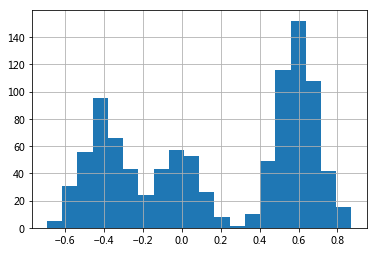

In [2]:
# 原始数据
cluster_data = pd.read_csv("./cluster_data.csv")
data = cluster_data["data"]
data_labels = cluster_data["label"]

_=data.hist(bins=20)

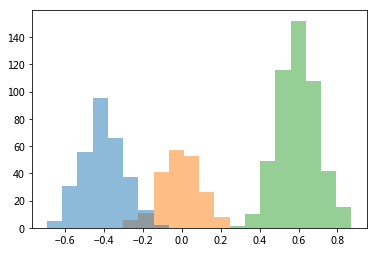

In [3]:
def plot_clusters(data_points, data_assigns):
    gby = pd.DataFrame({
            'data': data_points, 
            'assignment': data_assigns}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

# 真实的 cluster label下绘制的直方图
plot_clusters(data, data_labels)

### Bayesian GMM

假设方差已知 $\sigma^2 = 0.01$

观测到的数据为 $ x_1, x_2, ..., x_n $, 相应的隐含类别为 $ z_1, ..., z_n $.

模型的参数为 $\theta = (\pi_1, ..., \pi_K, u_1, ..., u_K)$, 其中 $K$ 为 cluster 的数目.

为这些参数引入先验: 

$\pi = (\pi_1, ..., \pi_K) \sim Dirichlet(\alpha)$

$u_k \sim Normal(\lambda_0, \lambda_1^2) \quad \forall k = 1, 2, ..., K $

现在要估计的是分布 $p(z_1, ..., z_n, \pi_1, ..., \pi_K, u_1, ..., u_K | x_1, ..., x_n)$

下面会分别展示 MCMC 的方法 和 Variational Inference 的方法来求解模型.

### 用 Gibbs 采样求解

- **估计 $p(z_i | z_{-i}, \pi, x, u)$**

    $p(z_i = k| z_{-i}, \pi, x, u) \propto \pi_{k} N(x_i | u_{k}, \sigma^2)$

- **估计 $p(\pi | z, x, u)$**

    已经假定了 $\pi$ 的先验分布为 symmetric Dirichlet distribution, 参数为 $\alpha$. 
    
    根据多项分布和 Dirichlet distribution 的共轭性质, 容易得到后验分布为:
    
    $ p(\pi | z, x, u) = Dirchlet(\sum \delta(z_i,1) + \alpha, \sum \delta(z_i,2) + \alpha, ..., \sum \delta(z_i,K) + \alpha) $

- **估计 $p(u_i | z, x, \pi)$**

    已经假定了 $u_i$ 服从的先验分布为 $Normal(\lambda_0, \lambda_1^2)$
    
    容易得到后验分布为:
    
    $ p(u_i | z, x, \pi) = Normal(u_i | mean_i, var_i) $
    
    其中:
    
    $ var_i = (\frac{1}{\lambda_1^2} + \frac{N_k}{\sigma^2})^{-1} $
    
    $ mean_i = var_i (\frac{\lambda_0}{\lambda_1^2} + \frac{n \bar{x_i}}{\sigma^2})$
    
    上面公式中的 $N_i$ 表示的是 cluster i 中 data point 的数目, $\bar{x_i}$ 表示 cluster i 中 data point 的样本均值.

### 参考资料

- [Bayesian Mixture Models and the Gibbs Sampler](http://www.cs.columbia.edu/~blei/fogm/2015F/notes/mixtures-and-gibbs.pdf)

- [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

- [blog: Fitting a Mixture Model with Gibbs Sampling](https://dp.tdhopper.com/mixture-model/)

In [4]:
from scipy.stats import dirichlet, norm


class BayesianGMM:
    
    def __init__(self, n_clusters=3, variance=0.01):
        self.n_clusters = n_clusters
        self.variance = variance
        self.std = np.sqrt(self.variance)
    
    def fit(self, data, num_epoches=10, alpha=1, lambda0=0, lambda1=1, verbose=False):
        '''
        @param alpha: symmetric Dirichlet distribution 的参数
        @param lambda0: 均值的先验高斯分布的均值
        @param lambda1: 均值的先验高斯分布的标准差
        '''
        data_size = data.shape[0]
        # initialize all the parameters
        data_assigns = np.random.randint(low=0, high=self.n_clusters, size=data_size)
        prior_mean = lambda0
        prior_var = np.power(lambda1, 2)
        
        ss = pd.Series(data)
        for i_epoch in range(num_epoches):
            grouped = data.groupby(data_assigns)
            
            # sample p(\pi)
            sample_counter = grouped.count()
            self.pi = dirichlet([alpha + sample_counter.get(i, 0) for i in range(self.n_clusters)]).rvs(1)[0]

            # sample p(u_i)
            sample_mean = grouped.mean()
            var = [1 / (1/prior_var + sample_counter.get(i, 0) / self.variance) for i in range(self.n_clusters)]
            mean = np.array(var) * np.array([prior_mean / prior_var + sample_counter.get(i, 0) * sample_mean.get(i, 0) / self.variance for i in range(self.n_clusters)])
            self.u = [norm.rvs(loc=mean[i], scale=np.sqrt(var[i]), size=1)[0] for i in range(self.n_clusters)] 
            

            # sample p(z_i | z_{-i})
            for data_i, data_point in enumerate(data):
                prob = np.array([self.pi[k] * norm.pdf(data_point, loc=self.u[k], scale=self.std) for k in range(self.n_clusters)])
                prob = prob / prob.sum()
                data_assigns[data_i] = np.random.choice(self.n_clusters, p=prob)
            
            if verbose:
                print("---------- iter: %s ----------" % i_epoch)
                # print("\t".join("{}:{}".format(data_i, data_cnt) for data_i, data_cnt in sample_counter.items()))
                print("u:", self.u)
        
        return data_assigns


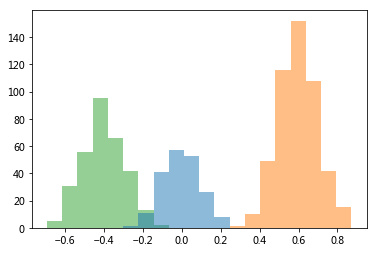

In [5]:
bgmm = BayesianGMM()
data_assigns = bgmm.fit(data, num_epoches=100)

plot_clusters(data, data_assigns)